# <h1 style="text-align:center;">**First Data Analysis:**</h1>

---

### **Project Presentation**

This Jupyter notebook defines the methodology for **ingestion**, **processing**, and **enrichment** of data for the ANSSI alert project. The objective is to consolidate disparate sources (RSS feeds, threat metrics, and weakness repositories) into a single, actionable data structure for our cybersecurity application.

### **Methodological Approach**

The workflow is broken down into three critical phases:

1. **Initial Collection and Transformation**:
* Retrieval of security bulletins via the **ANSSI RSS feed**.
* Structuring raw data into a first **Pandas** DataFrame.


2. **API Enrichment (Threat Vector)**:
* Extraction of **CVE** (Common Vulnerabilities and Exposures) identifiers.
* API calls to integrate **EPSS** (Exploit Prediction Scoring System) scores, measuring the real probability of vulnerability exploitation.


3. **Business Consolidation (MITRE Repository)**:
* Querying the **MITRE API** to retrieve contextual metadata (descriptions, CWE weakness types).
* Creation of a second normalized DataFrame based on the `CVE` primary key.



### **Expected Result**

The process concludes with the **merging** of the two datasets. We obtain a final enriched DataFrame, offering a 360° view of each alert: from its official publication to its technical severity score, thus constituting the data engine of our application.

---

In [1]:
import feedparser # To retrieve data from an RSS feed
import numpy as np
import pandas as pd
import time
import datetime
import requests # To make API requests
import re

# **I - ANSSI Data Retrieval:**
ANSSI writes alerts and advisories on security vulnerabilities. Thus, we retrieve the RSS feed in the form of a parsefeeddict:

In [2]:
anssi_feed = feedparser.parse("https://www.cert.ssi.gouv.fr/feed/")

The data is in list form under the "entries" key. Let's take the time to look at how the data is presented.

In [3]:
if anssi_feed.entries:
    for k,v in anssi_feed.entries[1].items():
        print(f"[{k} | {type(v)}] -> {v}", end = "\n")

[title | <class 'str'>] -> Multiples vulnérabilités dans Google Chrome (11 décembre 2025)
[title_detail | <class 'feedparser.util.FeedParserDict'>] -> {'type': 'text/plain', 'language': None, 'base': 'https://www.cert.ssi.gouv.fr/feed/', 'value': 'Multiples vulnérabilités dans Google Chrome (11 décembre 2025)'}
[links | <class 'list'>] -> [{'rel': 'alternate', 'type': 'text/html', 'href': 'https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-AVI-1096/'}]
[link | <class 'str'>] -> https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-AVI-1096/
[summary | <class 'str'>] -> De multiples vulnérabilités ont été découvertes dans Google Chrome. Elles permettent à un attaquant de provoquer un problème de sécurité non spécifié par l'éditeur.
[summary_detail | <class 'feedparser.util.FeedParserDict'>] -> {'type': 'text/html', 'language': None, 'base': 'https://www.cert.ssi.gouv.fr/feed/', 'value': "De multiples vulnérabilités ont été découvertes dans Google Chrome. Elles permettent à un attaquant de provoquer 

To summarize, the RSS feed returns:
| Element | Type | Description |
| --- | --- | --- |
| **`title`** | `str` | The title of the alert. Here, it contains the product name and the initial publication date. |
| **`title_detail`** | `dict` | Contains metadata about the title: its format (`text/plain`), language, and source URL (`base`). |
| **`links`** | `list` | A list of dictionaries containing associated links. It often contains the link to the official HTML page. |
| **`link`** | `str` | The direct URL to the alert on the CERT-FR site (shortcut of the first link in `links`). |
| **`summary`** | `str` | A text summary (often with HTML). |
| **`summary_detail`** | `dict` | Technical details of the summary. |
| **`id`** | `str` | The unique identifier of the entry (often identical to the URL). |
| **`guidislink`** | `bool` | Indicates if the identifier (`id`) is a usable URL link. |
| **`published`** | `str` | The publication date in text format. |
| **`published_parsed`** | `struct` | The date converted into a `time.struct_time` object, allowing for easy sorting of CVEs by year or month. |

---

Some data is useless to us. For example: `summary`, `isguidislink`, `id`, and `links` do not interest us. In the case of `title_detail` and `summary_detail`, we will reformat the data structure to keep only what is relevant.

In [4]:
for i in range(len(anssi_feed.entries)):
    # Some data is stored in sub-lists or sub-dictionaries, we retrieve only part of this data
    if "title_detail" in anssi_feed.entries[i] and type(anssi_feed.entries[i]["title_detail"]) == feedparser.util.FeedParserDict:
        anssi_feed.entries[i]["title"] = anssi_feed.entries[i]["title_detail"]["value"]

    if "summary_detail" in anssi_feed.entries[i] and type(anssi_feed.entries[i]["summary_detail"]) == feedparser.util.FeedParserDict:
        anssi_feed.entries[i]["summary_detail"] = anssi_feed.entries[i]["summary_detail"]["value"]

    if "published_parsed" in anssi_feed.entries[i]:
        anssi_feed.entries[i]["published"] = pd.to_datetime(datetime.datetime.fromtimestamp(time.mktime(anssi_feed.entries[i]["published_parsed"]))) # Transformation of the date to datetime format
        del anssi_feed.entries[i]["published_parsed"] # We prefer to keep only the date in datetime type and keep published as the key name

    # We remove what we don't need:
    if "summary" in anssi_feed.entries[i]:
        del anssi_feed.entries[i]["summary"]
    if "id" in anssi_feed.entries[i]:
        del anssi_feed.entries[i]["id"]
    if "guidislink" in anssi_feed.entries[i]:
        del anssi_feed.entries[i]["guidislink"]
    if "title_detail" in anssi_feed.entries[i]:
        del anssi_feed.entries[i]["title_detail"]
    if "links" in anssi_feed.entries[i]:
        del anssi_feed.entries[i]["links"]

We can now pass this data into a dataframe which we sort by publication date (from most recent to oldest). The most recent is the largest index.

In [5]:
anssi_df = pd.DataFrame.from_dict(anssi_feed.entries)
anssi_df.sort_index(ascending=False)

,title,link,summary_detail,published
39,Multiples vulnérabilités dans le noyau Linux d...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-26
38,Multiples vulnérabilités dans le noyau Linux d...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-26
37,Multiples vulnérabilités dans les produits IBM...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-26
36,Multiples vulnérabilités dans le noyau Linux d...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-26
35,Multiples vulnérabilités dans VMware Tanzu Pla...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-26
34,Bulletin d'actualité CERTFR-2025-ACT-056 (22 d...,https://www.cert.ssi.gouv.fr/actualite/CERTFR-...,Ce bulletin d'actualité du CERT-FR revient sur...,2025-12-22
33,Multiples vulnérabilités dans les produits Ela...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-19
32,Multiples vulnérabilités dans Mozilla Firefox ...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-19
31,Multiples vulnérabilités dans le noyau Linux d...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-19
30,Multiples vulnérabilités dans MongoDB Server (...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-19


There are two types of ANSSI publications, alerts and advisories. Let's create a column that categorizes the publications based on the link.

In [6]:
conditions = [
    anssi_df["link"].str.contains("alerte", case=False, na=False),
    anssi_df["link"].str.contains("avis", case=False, na=False)
]
anssi_df["type_publication"] = np.select(conditions, ["alerte", "avis"], default=None)

anssi_df = anssi_df.dropna(subset=["type_publication"]) # We remove everything that is neither an advisory nor an alert

In [7]:
anssi_df.head()

,title,link,summary_detail,published,type_publication
0,Multiples vulnérabilités dans MISP (08 décembr...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-08,avis
1,Multiples vulnérabilités dans Google Chrome (1...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-11,avis
2,Multiples vulnérabilités dans les produits IBM...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-12,avis
3,Multiples vulnérabilités dans Microsoft Edge (...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-12,avis
4,Multiples vulnérabilités dans le noyau Linux d...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-12,avis


# **II - Retrieval of the CVE (Common Vulnerabilities and Exposures):**

The CVE is a unique key that identifies a vulnerability. The ANSSI feed does not directly provide this identifier, which is why we will scrape the page of each alert/advisory to get the CVEs.

In [8]:
session = requests.Session() # Creating a session helps reduce execution time during many requests

def get_cve(anssi_url): # The function was optimized with Gemini Pro
    if not isinstance(anssi_url, str) or not anssi_url.strip(): # Ensuring the validity of the input argument
        return []

    target_url = anssi_url.rstrip("/") + "/json/" # Retrieving the json of the page
    
    try:
        # Using the global session
        response = session.get(target_url, timeout=5) 
        
        if response.status_code == 200: # If the request succeeds
            # Method 1: using REGEX
            # return list(set(re.findall(r"CVE-\d{4}-\d{4,7}", response.text)) )# set() for deduplication, list() for the final format
        
            # Method 2: Going through the cves key:
            return [ v["name"] for v in response.json()["cves"] ]
            
    except requests.RequestException: # In case of network error (timeout, 404...), we return an empty list
        print("Nothing was found on ", anssi_url)
        return []
    
    return []

print(anssi_df["link"][0]) # Example link
print(get_cve(anssi_df["link"][0])) # Testing the function for an ANSSI alert

https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-AVI-1076/
['CVE-2025-67906']


We just have to apply this function to the entire dataframe to create a CVE column.

In [9]:
anssi_df["cve"] = anssi_df["link"].transform(get_cve) # Returns the list of CVEs

But some publications do not have a CVE. This happens because sometimes ANSSI publishes recommendations on practices or to be vigilant about certain things. Thus, there is no referenced vulnerability with a CVE. This does not mean we should delete them from our dataframe.

In [10]:
anssi_df[anssi_df["cve"].str.len() == 0] # Rows without CVE

,title,link,summary_detail,published,type_publication,cve
8,Multiples vulnérabilités dans Roundcube (15 dé...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-15,avis,[]


It often happens that an ANSSI alert/advisory refers to several CVEs, but in the end, we want a Dataframe that gives information for each CVE vulnerability and not each ANSSI alert/advisory.
That is why we will unpack these CVEs so that each CVE has its own row. Thus, one ANSSI alert can be associated with several CVEs.
To do this, we use the `explode` method of dataframes.

In [11]:
anssi_df = anssi_df.explode("cve")
anssi_df = anssi_df.reset_index(drop=True) # We reset the index because explode "duplicates" the indices. The drop argument removes the old index

Here are the first 5 elements of the ANSSI alert dataframe.

In [12]:
anssi_df.head()

,title,link,summary_detail,published,type_publication,cve
0,Multiples vulnérabilités dans MISP (08 décembr...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-08,avis,CVE-2025-67906
1,Multiples vulnérabilités dans Google Chrome (1...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-11,avis,CVE-2025-14372
2,Multiples vulnérabilités dans Google Chrome (1...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-11,avis,CVE-2025-14373
3,Multiples vulnérabilités dans Google Chrome (1...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-11,avis,CVE-2025-14174
4,Multiples vulnérabilités dans les produits IBM...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-12,avis,CVE-2022-50367


# **III - Enrichment of the ANSSI dataframe with the EPSS score using the EPSS API:**
The EPSS score represents the probability that a vulnerability will be exploited.

In [13]:
epss_api_url = "https://api.first.org/data/v1/epss?cve=" 

def get_epss_data(cve): 
    target_url = epss_api_url + cve
    
    try:
        res = session.get(target_url, timeout=5)

        if res.status_code != 200:
            print(res.status_code)
            return {}

        data = res.json()
        
        epss_data = data.get("data", [])

        if epss_data != []:
            return float(epss_data[0]["epss"]) or np.nan

        return np.nan
    except Exception:
        print("Nothing was found for ", cve)
        return np.nan

print(anssi_df["cve"][0]) # A CVE identifier
print(get_epss_data(anssi_df["cve"][0])) # Testing the function for 1 CVE

CVE-2025-67906
0.00035


In [14]:
anssi_df["epss_score"] = anssi_df["cve"].transform(lambda x: get_epss_data(x) if (pd.notna(x)) else np.nan) # We apply the function only if the CVE is not null

In [15]:
anssi_df.head()

,title,link,summary_detail,published,type_publication,cve,epss_score
0,Multiples vulnérabilités dans MISP (08 décembr...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-08,avis,CVE-2025-67906,0.00035
1,Multiples vulnérabilités dans Google Chrome (1...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-11,avis,CVE-2025-14372,0.00040
2,Multiples vulnérabilités dans Google Chrome (1...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-11,avis,CVE-2025-14373,0.00030
3,Multiples vulnérabilités dans Google Chrome (1...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-11,avis,CVE-2025-14174,0.00530
4,Multiples vulnérabilités dans les produits IBM...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-12,avis,CVE-2022-50367,0.00016


# **IV - Retrieval of MITRE Data:**
We will create a second dataframe containing all the data provided by the MITRE API.

By looking closer at how the MITRE system and its [API](https://cveawg.mitre.org/api-docs/) work, we discovered that there are 3 states for a CVE:
| State | Definition |
| :--- | :--- |
| **`RESERVED`** | A CVE number has been assigned to an organization (a vendor or a researcher), but the details of the vulnerability are not yet public. |
| **`PUBLISHED`** | The vulnerability is official, technical details are available, and the analysis process is complete (or in progress). |
| **`REJECTED`** | The CVE has been cancelled. This happens if the vulnerability was a duplicate of another, if it was a reporting error, or if the vulnerability turned out not to be one. |

The MITRE API `https://cveawg.mitre.org/api/cve/{CVE}` returns the state of the CVE if the CVE is not reserved. If it is reserved, the call returns a 404 error (Page not found).

It is possible to verify the state of the CVE upon a 404 response with `https://cveawg.mitre.org/api/cve-id/{CVE}`. 
However, we will not make these calls for performance reasons and because we are already certain we can filter out rejected and reserved CVEs.
We remove all those rejected because they are no longer relevant and all those reserved because we have no information on the vulnerability, so nothing to report to our end user.

In [16]:
mitre_api_url = "https://cveawg.mitre.org/api/cve/"

def get_mitre_data(cve):
    if pd.isna(cve):
        return {}
    
    target_url = mitre_api_url + cve
    
    try:
        res = session.get(target_url, timeout=5)
        if res.status_code != 200:
            print(f"[ERROR-{res.status_code}] {cve}")

            return {}

        data = res.json()

        # We verify the state of the CVE
        cveMetadata = data.get("cveMetadata", {})
        if cveMetadata != {}:
            if cveMetadata["state"] != "PUBLISHED": # If it is not published, we ignore it
                return {}

        cna = data.get("containers", {}).get("cna", {})
        
        # Secure extraction of the description
        descriptions = cna.get("descriptions", [])
        desc = descriptions[0].get("value", None) if descriptions else None

        # Secure extraction of the CWE
        problem_types = cna.get("problemTypes", [])
        cwe_id = np.nan
        cwe_desc = np.nan
        
        if problem_types:
            # We often take the first listed problem type
            desc_list = problem_types[0].get("descriptions", [])
            if desc_list:
                cwe_id = desc_list[0].get("cweId", np.nan)
                cwe_desc = desc_list[0].get("description", np.nan)

        metrics = cna.get("metrics", [])
        cvss_score = None
        if metrics != []:
            metrics = metrics[0]
            for k in metrics.keys():
                if "cvss" in k.lower():
                    cvss_score = float(metrics[k]["baseScore"])
                    break

        # Construction of the final dictionary
        return {
            "cve": cve,
            "cwe": cwe_id,
            "cwe_desc": cwe_desc,
            "cvss_score": cvss_score,
            "mitre_desc": desc,
            "affected_product": [ # By list comprehension method
                {
                    "vendor": prod.get("vendor"),
                    "product": prod.get("product"),
                    "versions": [v.get("version") for v in prod.get("versions", []) if v.get("status") == "affected"]
                }
                for prod in cna.get("affected", [])
            ]
        }
    except Exception:
        return {}

print(anssi_df["cve"][3])
print(get_mitre_data(anssi_df["cve"][3]))

CVE-2025-14174
{'cve': 'CVE-2025-14174', 'cwe': nan, 'cwe_desc': 'Out of bounds memory access', 'cvss_score': None, 'mitre_desc': 'Out of bounds memory access in ANGLE in Google Chrome on Mac prior to 143.0.7499.110 allowed a remote attacker to perform out of bounds memory access via a crafted HTML page. (Chromium security severity: High)', 'affected_product': [{'vendor': 'Google', 'product': 'Chrome', 'versions': ['143.0.7499.110']}]}


In [17]:
# Singlethread version
# mitre_data = [ get_mitre_data(cve) for cve in anssi_df["cve"] ] # This execution takes time because it makes requests for each row of the df

In [18]:
"""
This is multithreading which we won't keep in the final version of the notebook because it's not the place for it.
"""

# Multithread version

from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm # To see the progress bar

# 1. We retrieve the list of unique CVEs to avoid unnecessary calls
liste_cves = anssi_df['cve'].unique().tolist()

# 2. Configuration of the number of threads (ex: 10 to 20)
# Too many threads can cause API blocking (Rate Limiting)
MAX_WORKERS = 15 

print(f"Retrieving {len(liste_cves)} CVEs in progress...")

# 3. Parallel execution
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    # We use tqdm to follow progress
    mitre_data = list(tqdm(executor.map(get_mitre_data, liste_cves), total=len(liste_cves)))



Retrieving 1049 CVEs in progress...


  4%|▍         | 44/1049 [00:01<00:23, 43.13it/s]

[ERROR-404] CVE-2025-9615


 11%|█         | 117/1049 [00:01<00:08, 104.79it/s]

[ERROR-404] CVE-2025-67848
[ERROR-404] CVE-2025-67850
[ERROR-404] CVE-2025-67851
[ERROR-404] CVE-2025-67849
[ERROR-404] CVE-2025-67852
[ERROR-404] CVE-2025-67853
[ERROR-404] CVE-2025-67856
[ERROR-404] CVE-2025-67854
[ERROR-404] CVE-2025-67855
[ERROR-404] CVE-2025-67857
[ERROR-404] CVE-2025-14713
[ERROR-404] CVE-2025-66593
[ERROR-404] CVE-2025-66592
[ERROR-404] CVE-2025-14177
[ERROR-404] CVE-2025-14180
[ERROR-404] CVE-2025-14178


 29%|██▊       | 301/1049 [00:02<00:04, 176.22it/s]

[ERROR-404] CVE-2025-33134


 37%|███▋      | 383/1049 [00:03<00:04, 164.81it/s]

[ERROR-404] CVE-2025-59488
[ERROR-404] CVE-2025-57779
[ERROR-404] CVE-2025-58085


100%|██████████| 1049/1049 [00:07<00:00, 145.94it/s]

[ERROR-404] CVE-2023-43020


In [19]:
mitre_df = pd.DataFrame(mitre_data) # We transform our data into a df 
mitre_df = mitre_df.dropna(subset=['cve']) # This line removes rejected and reserved CVEs
mitre_df = mitre_df.reset_index(drop=True)

mitre_df.head() # We display the first 5 rows

,cve,cwe,cwe_desc,cvss_score,mitre_desc,affected_product
0,CVE-2025-67906,CWE-79,CWE-79 Improper Neutralization of Input During...,5.4,"In MISP before 2.5.28, app/View/Elements/Workf...","[{'vendor': 'MISP', 'product': 'MISP', 'versio..."
1,CVE-2025-14372,CWE-416,Use after free,NaN,Use after free in Password Manager in Google C...,"[{'vendor': 'Google', 'product': 'Chrome', 've..."
2,CVE-2025-14373,NaN,Inappropriate implementation,NaN,Inappropriate implementation in Toolbar in Goo...,"[{'vendor': 'Google', 'product': 'Chrome', 've..."
3,CVE-2025-14174,NaN,Out of bounds memory access,NaN,Out of bounds memory access in ANGLE in Google...,"[{'vendor': 'Google', 'product': 'Chrome', 've..."
4,CVE-2022-50367,NaN,NaN,NaN,"In the Linux kernel, the following vulnerabili...","[{'vendor': 'Linux', 'product': 'Linux', 'vers..."


By proceeding in this way, only published CVEs that represent a real threat remain in our df. 

# **V - Creation of the alert database:**
We now have all the information to create the final DataFrame with all the information necessary for our application. Here is the structure of the dataframe we want:

| Column Name | Definition & Details |
| :--- | :--- |
| **`anssi_title`** | Title of the ANSSI alert/advisory |
| **`anssi_link`** | Link to the ANSSI alert/advisory |
| **`anssi_desc`** | Description of the ANSSI alert/advisory |
| **`anssi_published`** | Publication date of the ANSSI alert/advisory |
| **`cve`** | Unique identifier of the table, unique number referring to the vulnerability |
| **`epss_score`** | EPSS Score, Probability that the vulnerability is exploited |
| **`cwe`** | The CWE (Common Weakness Enumeration) is a universal classification system that lists security weaknesses in software and hardware. |
| **`cwe_desc`** | CWE Description |
| **`cvss_score`** | CVSS Score, severity of the vulnerability |
| **`mitre_desc`** | Description returned by the Mitre API |
| **`affected_product`** | List of affected products table with vendor name, affected product, and vulnerable versions |


We will create this dataframe by merging mitre_df and anssi_df on the CVE column values.

In [20]:
anssi_df.columns = ['anssi_title', 'anssi_link', 'anssi_desc', 'anssi_published', 'type_publication', 'cve', 'epss_score'] # Renaming column names

DB = anssi_df.merge(mitre_df, on='cve', how='left')

In [21]:
def set_severity(cvss_score):
    if pd.isna(cvss_score):
        return np.nan
    
    if cvss_score >= 9:
        return "Critical"
    elif cvss_score >= 7:
        return "High"
    elif cvss_score >= 4:
        return "Medium"
    else:
        return "Low"

DB["base_severity"] = DB["cvss_score"].transform(set_severity)

In [22]:
DB

,anssi_title,anssi_link,anssi_desc,anssi_published,type_publication,cve,epss_score,cwe,cwe_desc,cvss_score,mitre_desc,affected_product,base_severity
0,Multiples vulnérabilités dans MISP (08 décembr...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-08,avis,CVE-2025-67906,0.00035,CWE-79,CWE-79 Improper Neutralization of Input During...,5.4,"In MISP before 2.5.28, app/View/Elements/Workf...","[{'vendor': 'MISP', 'product': 'MISP', 'versio...",Medium
1,Multiples vulnérabilités dans Google Chrome (1...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-11,avis,CVE-2025-14372,0.00040,CWE-416,Use after free,NaN,Use after free in Password Manager in Google C...,"[{'vendor': 'Google', 'product': 'Chrome', 've...",NaN
2,Multiples vulnérabilités dans Google Chrome (1...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-11,avis,CVE-2025-14373,0.00030,NaN,Inappropriate implementation,NaN,Inappropriate implementation in Toolbar in Goo...,"[{'vendor': 'Google', 'product': 'Chrome', 've...",NaN
3,Multiples vulnérabilités dans Google Chrome (1...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-11,avis,CVE-2025-14174,0.00530,NaN,Out of bounds memory access,NaN,Out of bounds memory access in ANGLE in Google...,"[{'vendor': 'Google', 'product': 'Chrome', 've...",NaN
4,Multiples vulnérabilités dans les produits IBM...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-12,avis,CVE-2022-50367,0.00016,NaN,NaN,NaN,"In the Linux kernel, the following vulnerabili...","[{'vendor': 'Linux', 'product': 'Linux', 'vers...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1272,Multiples vulnérabilités dans le noyau Linux d...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-26,avis,CVE-2024-53218,0.00038,NaN,NaN,NaN,"In the Linux kernel, the following vulnerabili...","[{'vendor': 'Linux', 'product': 'Linux', 'vers...",NaN
1273,Multiples vulnérabilités dans le noyau Linux d...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-26,avis,CVE-2024-53090,0.00016,NaN,NaN,NaN,"In the Linux kernel, the following vulnerabili...","[{'vendor': 'Linux', 'product': 'Linux', 'vers...",NaN
1274,Multiples vulnérabilités dans le noyau Linux d...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-26,avis,CVE-2024-50067,0.00034,NaN,NaN,NaN,"In the Linux kernel, the following vulnerabili...","[{'vendor': 'Linux', 'product': 'Linux', 'vers...",NaN
1275,Multiples vulnérabilités dans le noyau Linux d...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,De multiples vulnérabilités ont été découverte...,2025-12-26,avis,CVE-2025-39946,0.00021,NaN,NaN,NaN,"In the Linux kernel, the following vulnerabili...","[{'vendor': 'Linux', 'product': 'Linux', 'vers...",NaN


---

# **VI - Data Interpretation, Analysis, and Visualization:**

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

## 1) Vulnerability Severity Histogram:

### *a. Results Formatting:*

Text(0, 0.5, 'Occurrence')

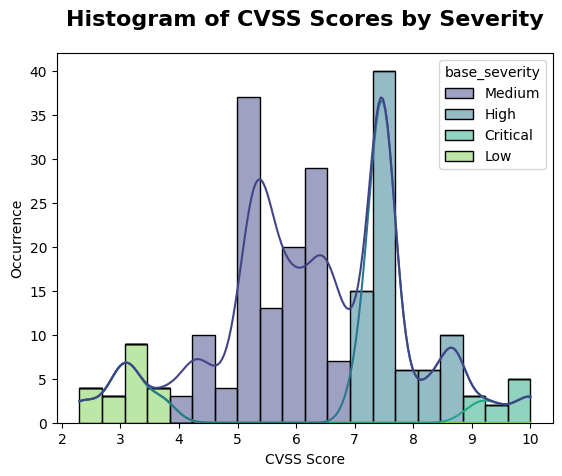

In [24]:
sns.histplot(data=DB, x="cvss_score", hue = "base_severity", 
             palette="viridis", # Color palette
             kde=True, # Kernel Density Estimate: Represents data trends
             bins=20, # Number of vertical bars
             multiple="stack")
plt.title("Histogram of CVSS Scores by Severity", fontsize=16, pad=20, fontweight='bold')
plt.xlabel("CVSS Score")
plt.ylabel("Occurrence")

### *b. Interpretation:*

The histogram reveals a multimodal distribution of vulnerabilities, with a major concentration located in the High score zone (7.0 - 9.0). This indicates that the analyzed data stream primarily consists of serious threats requiring rapid remediation, rather than minor vulnerabilities. The color overlay shows a precise correlation between the numerical CVSS score and the severity category (`base_severity`). The density curve (KDE) confirms this trend by clearly isolating three risk clusters: a "Medium" group centered around 5.2, a dominant "High" group at 7.5, and an isolated "Critical" group at the far right.

## 2) Vulnerability Severity Pie Chart:

### *a. Data Preparation:*

In [25]:
data2 = DB["base_severity"].value_counts() # Retrieve occurrences for each severity level

### *b. Results Formatting:*

Text(0.5, 1.0, 'Vulnerability Severity Distribution:')

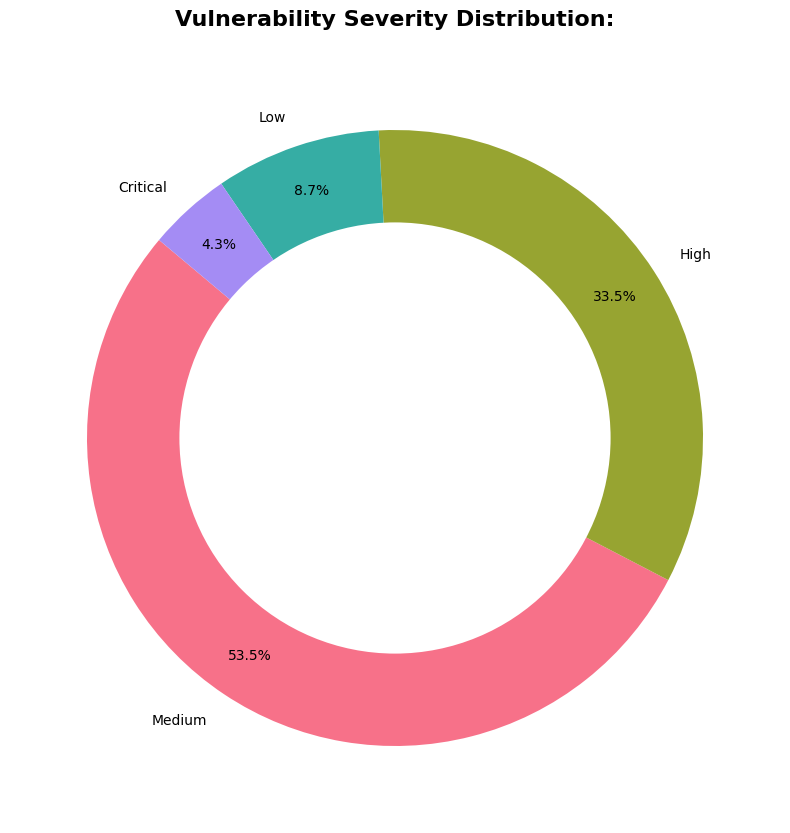

In [26]:
plt.figure(figsize=(10, 10))
colors = sns.color_palette('husl', 4)
plt.pie(data2, labels=data2.index, 
        autopct='%1.1f%%', # Display percentage
        pctdistance=0.85, # Move percentages away from center
        startangle=140,
        colors=colors # Change default colors
        )

# (Aesthetic choice) Add a hole in the middle to create a donut chart for better visibility
centre_cercle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf() # Get current figure
fig.gca().add_artist(centre_cercle) # Add circle to the pie chart

plt.title("Vulnerability Severity Distribution:", fontsize=16, pad=20, fontweight='bold')

### *c. Interpretation:*

The severity distribution reveals a flow focused on actual danger: over 92% of published vulnerabilities have an impact qualified as Medium to Critical. The predominance of "Medium" and "High" flaws highlights intense preventive maintenance activity, while the "Critical" segment (4.8%), though smaller, represents immediate threats.

## 3) Vendors most affected by vulnerabilities:

### *a. Data Preparation:*

In [27]:
data3 = DB[["cve", "affected_product", "cwe"]].explode('affected_product') # CWE is not used in Part 3, but will be in Part 5
data3.reset_index(drop=True)

,cve,affected_product,cwe
0,CVE-2025-67906,"{'vendor': 'MISP', 'product': 'MISP', 'version...",CWE-79
1,CVE-2025-14372,"{'vendor': 'Google', 'product': 'Chrome', 'ver...",CWE-416
2,CVE-2025-14373,"{'vendor': 'Google', 'product': 'Chrome', 'ver...",NaN
3,CVE-2025-14174,"{'vendor': 'Google', 'product': 'Chrome', 'ver...",NaN
4,CVE-2022-50367,"{'vendor': 'Linux', 'product': 'Linux', 'versi...",NaN
...,...,...,...
2690,CVE-2024-50067,"{'vendor': 'Linux', 'product': 'Linux', 'versi...",NaN
2691,CVE-2025-39946,"{'vendor': 'Linux', 'product': 'Linux', 'versi...",NaN
2692,CVE-2025-39946,"{'vendor': 'Linux', 'product': 'Linux', 'versi...",NaN
2693,CVE-2024-47691,"{'vendor': 'Linux', 'product': 'Linux', 'versi...",NaN


In [28]:
data3 = data3.dropna(subset=["affected_product"])

# Assuming rows have non-null vendor, versions, or product values
data3["vendor"] = data3["affected_product"].apply(lambda x: x["vendor"])
data3["versions"] = data3["affected_product"].apply(lambda x: x["versions"])
data3["product"] = data3["affected_product"].apply(lambda x: x["product"])

data3 = data3[data3["vendor"] != "n/a"] # Remove all n/a entries

top_10_3 = data3["vendor"].value_counts().head(10)


### *b. Results Formatting:*

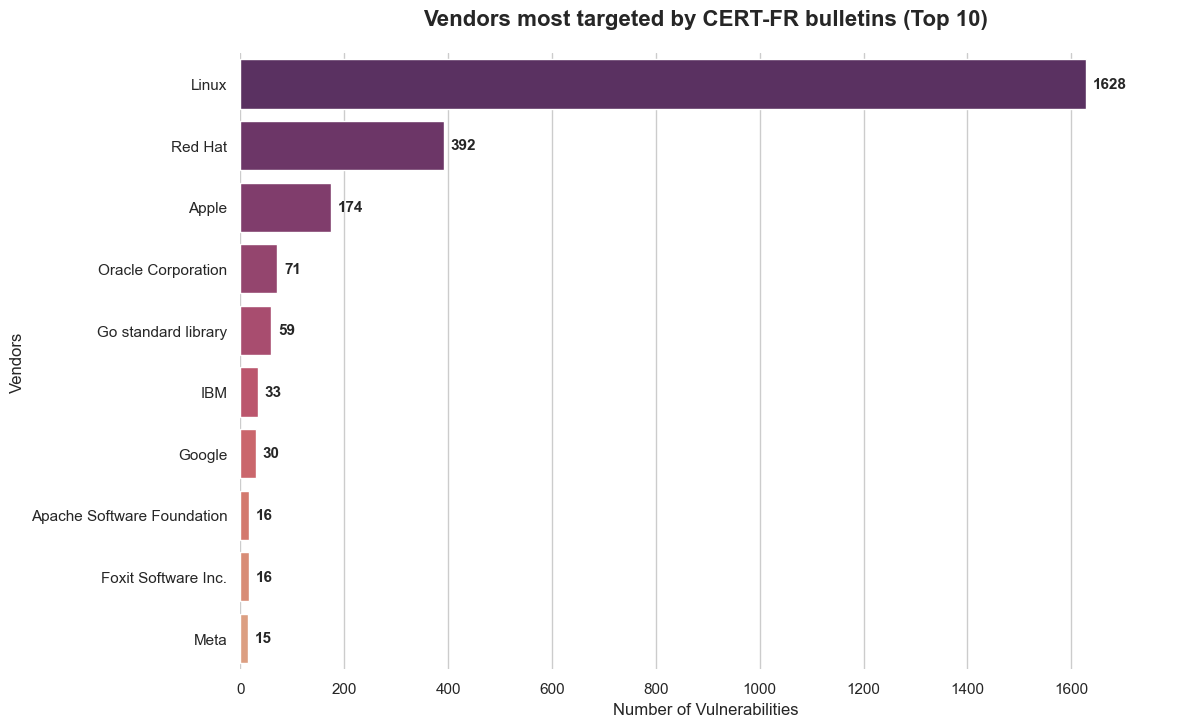

In [29]:
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid") # Clean background with discrete grid lines
ax = sns.barplot(x = top_10_3.values, y=top_10_3.index, palette="flare_r", hue = top_10_3.index)

plt.title("Vendors most targeted by CERT-FR bulletins (Top 10)", fontsize=16, pad=20, fontweight='bold')
plt.ylabel("Vendors")
plt.xlabel("Number of Vulnerabilities")
sns.despine(left=True, bottom=True) # Remove frame for aesthetic preference

# Add counts at the end of bars
plt.xlim(0, top_10_3.values.max() * 1.1)
for container in ax.containers:
    ax.bar_label(container, padding=5, fontweight='bold', fontsize=11)

### *c. Interpretation:*
The CERT-FR vulnerability landscape is overwhelmingly dominated by the Linux ecosystem, which alone accounts for more than three times the volume of flaws found in the next vendor. This concentration highlights the vital importance of Security Maintenance (MCS) for server and Open Source environments, which form the backbone of the information systems targeted by ANSSI bulletins.

## 4) Most Frequent Vulnerability Types (CWE):

### *a. Data Preparation:*

In [30]:
data4 = DB[["cwe", "cwe_desc"]]
data4 = data4.dropna(subset=["cwe"]) # Remove rows without CWE

# Group by CWE, count occurrences, and keep the first description found
top_10_4 = data4.groupby('cwe')['cwe_desc'].agg(
    occurrences='size', 
    description='first'
)

top_10_4 = top_10_4.sort_values(by='occurrences', ascending=False).head(10).reset_index()

top_10_4['description'] = top_10_4['description'].str.replace(r'^CWE-\d+:?\s*', '', regex=True) # Clean descriptions for uniformity
top_10_4['description'] = top_10_4['description'].replace('', 'Description unavailable')

top_10_4["label"] = top_10_4['cwe'] + ": " + top_10_4['description'] # Create a concatenated label column

### *b. Results Formatting:*

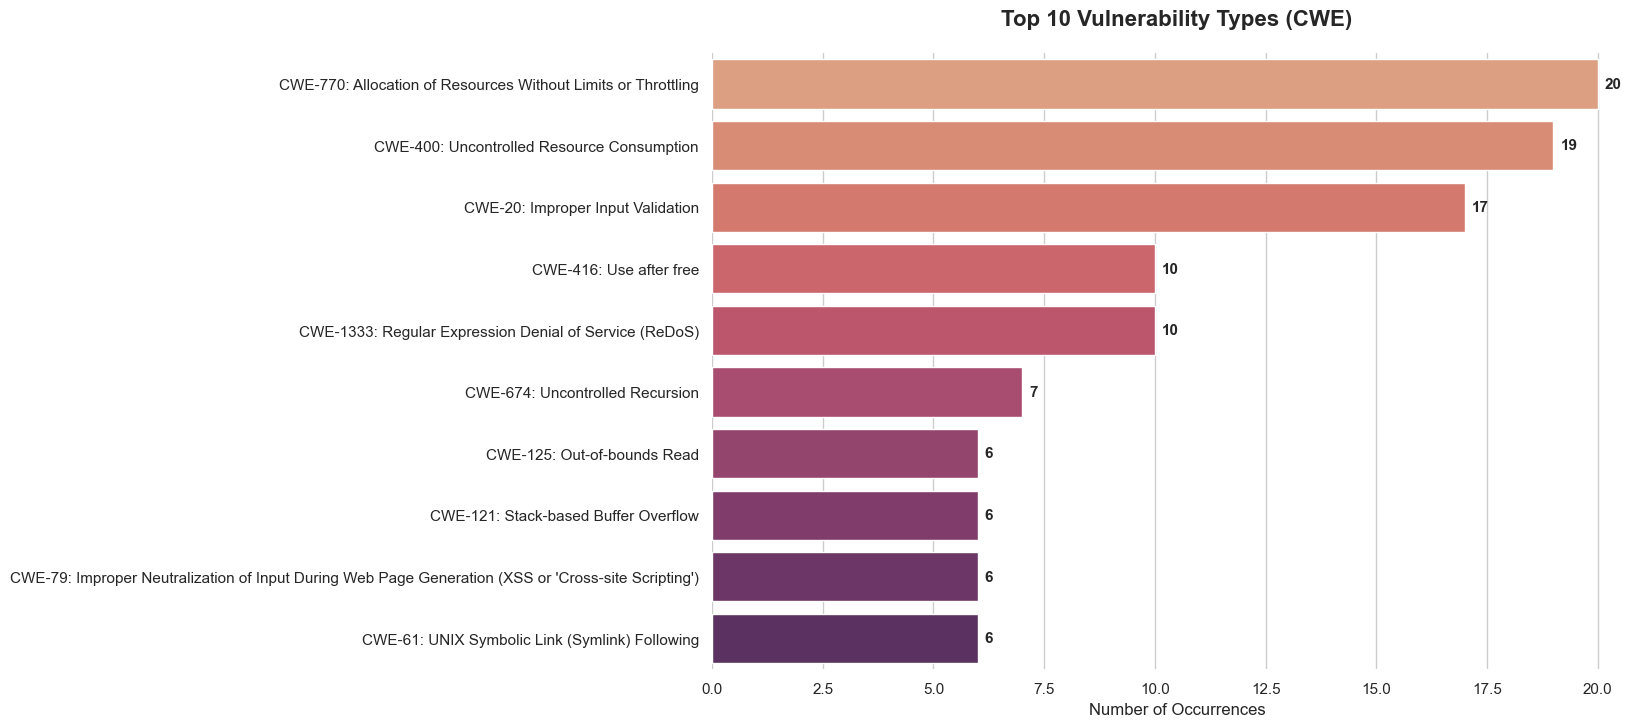

In [31]:
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")

ax = sns.barplot(
    data=top_10_4,
    x='occurrences',
    y='label', 
    hue='label',
    palette='flare',
    legend=False
)

for container in ax.containers:
    ax.bar_label(container, padding=5, fontweight='bold', fontsize=11)

plt.title("Top 10 Vulnerability Types (CWE)", fontsize=16, pad=20, fontweight='bold')
plt.xlabel("Number of Occurrences", fontsize=12)
plt.ylabel("") # Hide redundant Y label
sns.despine(left=True, bottom=True)

### *c. Interpretation:*

**Vendor Analysis: The Omnipresence of the Open Source Foundation**
The first chart shows extreme concentration on the Linux ecosystem (Linux + Red Hat combined represent nearly 1,900 bulletins).

- Linux Domination: With 1,495 flaws, Linux is the primary subject of CERT-FR. This is explained by its massive presence in critical infrastructure, servers, and the Cloud.

- Proprietary vs. Open Source Gap: There is a huge gap between Linux and players like Oracle (50) or Google (21). This suggests that CERT-FR monitoring is strongly oriented toward "low-level" components (kernels and system libraries) rather than end-user applications.

- Infrastructure vs. Apps: The presence of the Go standard library and players like Apache or Elastic confirms that risk is mainly located in the building blocks of information systems.
  
**CWE Analysis:**
- The Reign of Denial of Service (DoS): The top two flaws (CWE-770 and CWE-400) concern resource management. Together, they represent a major portion of risks, allowing an attacker to saturate a system and make it unavailable.

- Memory Management Fragility: The presence of CWE-416 (Use after free), CWE-125 (Out-of-bounds Read), and CWE-121 (Buffer Overflow) is typical of software written in C/C++ (like the Linux kernel). This is the historical weakness of low-level infrastructure.

- Absence of Classic "Web Flaws": CWE-79 (XSS) is very low in the ranking (5 occurrences). This confirms that CERT-FR bulletins deal less with simple web application vulnerabilities and more with system stability issues.

Thus, the cyber threat landscape revealed by this data highlights the hegemony of the Linux ecosystem in CERT-FR bulletins, where resource management (DoS) and memory corruption flaws constitute the priority risk vectors for critical infrastructure security.

## 5) Correlation Matrix:

### *a. Data Preparation:*

In [32]:
# Filter data to keep only the respective top 10
top_vendors = data3['vendor'].value_counts().head(10).index
top_cwes = data3['cwe'].value_counts().head(10).index

subset = data3[data3['vendor'].isin(top_vendors) & data3['cwe'].isin(top_cwes)]

matrix = pd.crosstab(subset['vendor'], subset['cwe']) # Use crosstab to create the matrix

### *b. Results Formatting:*

Text(117.24999999999997, 0.5, '')

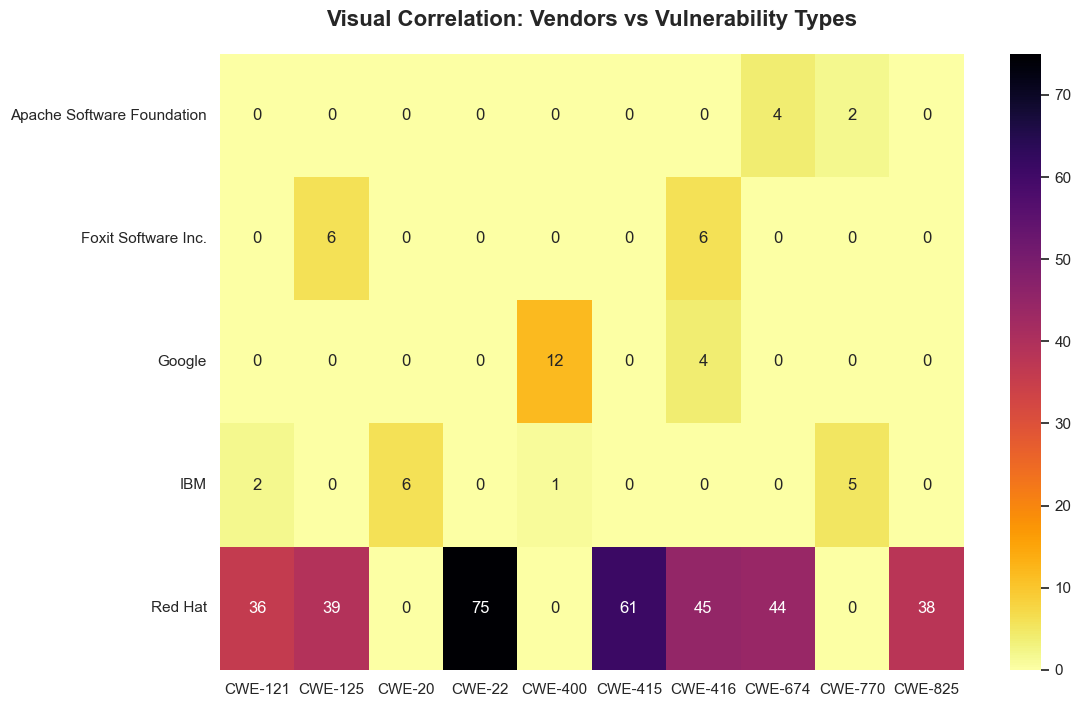

In [33]:
plt.figure(figsize=(12, 8))
sns.heatmap(matrix, annot=True, cmap="inferno_r")
plt.title("Visual Correlation: Vendors vs Vulnerability Types", fontsize=16, pad=20, fontweight='bold')
plt.xlabel("")
plt.ylabel("")

### *c. Interpretation:*
We have noted three key observations:

- Patching Priority: Remediation efforts should focus on Red Hat / Linux, which suffers not only from the highest volume of bulletins but also from the most technically varied flaws.

- Risk Vector #1: Availability (DoS via resource exhaustion) is the most frequent risk, but Memory Corruption is the deepest risk (often allowing Remote Code Execution).

- Data Observation: It is interesting to note that the correlation matrix shows numbers (e.g., 75 for Red Hat/CWE-22) much higher than the global occurrence chart. This suggests that a single bulletin can contain many CVEs, thereby multiplying the actual impact per vulnerability type.